In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging as logger
from sklearn.utils import shuffle
import string
import pickle
import tensorflow as tf
import os
from scipy import spatial
import argparse
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Bidirectional, LSTM,Embedding, Input, Dense, Activation, Conv1D, MaxPooling1D, Flatten, Concatenate, RepeatVector, dot, Reshape, Permute
from tensorflow.keras.models import Model, save_model,load_model


In [2]:
max_len = 64
pad_type = 'post'
trunc_type = 'post'
text_embedding = 128
embedding_dim = 300
oov_token = '<OOV>'
kfold = 5
model_gigaword = api.load("glove-wiki-gigaword-300")

In [3]:
train = pd.read_excel('data/Entity_sentiment_trainV2.xlsx')
test =  pd.read_excel('data/Entity_sentiment_testV2.xlsx')

In [4]:
train.head()

,Sentence,Entity,Sentiment
0,The website was very easy to use and my insura...,website,positive
1,The web sight was easy to understand and I got...,web sight,positive
2,Having filled in the application on-line I cou...,point,negative
3,After finding AXA was cheaper than my renewal ...,prices,positive
4,The quote was a reasonable price compared with...,insurances,positive


In [5]:
test.head()

,Sentence,Entity
0,I telephoned AXA customer service as we had a ...,staff
1,Got the quote on line which was very straightf...,axa
2,Not enough information on insurance details no...,information
3,It was admittedly at 11pm but they DO claim to...,service
4,Good servicewith very little hassleeasy to use...,price


positive    4100
negative    1899
Name: Sentiment, dtype: int64


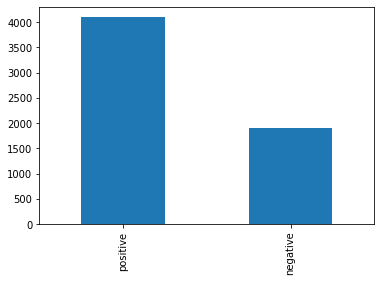

In [6]:
print(train['Sentiment'].value_counts())
train['Sentiment'].value_counts().plot(kind = 'bar')

In [7]:
##undersampling of majaority class
neg_len = len(train[train['Sentiment']=='negative'])
pos_index = train[train['Sentiment']=='positive'].index
ch_index = np.random.choice(pos_index, size = neg_len, replace = False,)
neg_index = train[train['Sentiment']=='negative'].index
index = np.concatenate([ch_index,neg_index])
us_train = train.loc[index]
us_train = shuffle(us_train)
us_train = us_train.reset_index(drop=True)
us_train.head()

,Sentence,Entity,Sentiment
0,We had a problem with water ingress through a ...,problem,negative
1,Lauren was very good and helped me to understa...,policy,positive
2,Great customer service & great price,price,positive
3,excellent service hope to get the same service...,service,positive
4,I hope I don't find out whether the AXA after ...,service,positive


In [8]:
##over-sampling of majaority class
neg_len = len(train[train['Sentiment']=='positive'])
pos_index = train[train['Sentiment']=='negative'].index
ch_index = np.random.choice(pos_index, size = neg_len, replace = True,)
neg_index = train[train['Sentiment']=='positive'].index
index = np.concatenate([ch_index,neg_index])
os_train = train.loc[index]
os_train = shuffle(os_train)
os_train = os_train.reset_index(drop=True)
os_train.head()

,Sentence,Entity,Sentiment
0,I found the form much simpler to fill in than ...,web site,positive
1,i couldn't get the website to accept my email ...,times,negative
2,Only annoyance is the need to opt out of autom...,automatic renewal,negative
3,Usually buy Lloyds/AXA singe trip insurance bu...,site,negative
4,I am not a computer buff but I found it very e...,questions,positive


In [9]:
print('original',train.shape)
print('under',us_train.shape)
print('over',os_train.shape)

original (5999, 3)
under (3798, 3)
over (8200, 3)


In [10]:
#Number of entity count
Ne = train['Entity'].value_counts()
Nc = Ne.rename_axis('unique_values').reset_index(name='counts')
Nc

,unique_values,counts
0,service,705
1,price,350
2,website,277
3,insurance,173
4,axa,144
...,...,...
743,bags,1
744,end,1
745,cancellation charge,1
746,computer systems,1


In [12]:
#relation between entity and sentimnt
res = pd.crosstab(train['Entity'], train['Sentiment'])
res.sort_values(['negative','positive'], ascending=[False,False])

Sentiment,negative,positive
Entity,,
insurance,69,104
service,59,646
website,53,224
policy,53,81
time,45,37
...,...,...
value product,0,1
values,0,1
webpage,0,1


In [13]:
wc = train['Sentence'].apply(lambda x: len(x.split()))
train['wc'] = wc
train.head()

,Sentence,Entity,Sentiment,wc
0,The website was very easy to use and my insura...,website,positive,20
1,The web sight was easy to understand and I got...,web sight,positive,16
2,Having filled in the application on-line I cou...,point,negative,22
3,After finding AXA was cheaper than my renewal ...,prices,positive,23
4,The quote was a reasonable price compared with...,insurances,positive,10


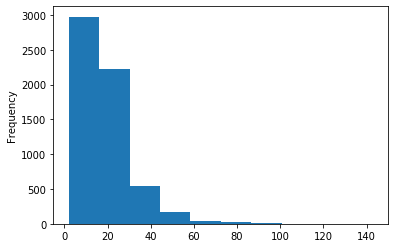

In [14]:
#plot word count histogram
k = train['wc'].sort_values(ascending=False)
k.plot(kind = 'hist')

In [17]:
#Number of example gretaer than 64
print(k[k>64].count())

61


In [18]:
def clean(text):
    trastab = str.maketrans(string.punctuation,' '*len(string.punctuation))
    text= text.translate(trastab)
    text = text.lower()
    text = ' '.join([word for word in text.split()])
    return text

def vocab_(data):
    words = []
    for row in data.index:
        words.extend(data['Sentence'][row].split())
    return set(words)

In [19]:
train['Sentence'] = train['Sentence'].apply(clean)
us_train['Sentence'] = us_train['Sentence'].apply(clean)
os_train['Sentence'] = os_train['Sentence'].apply(clean)
test['Sentence'] = test['Sentence'].apply(clean)
vocabs = vocab_(train)
vocab = len(vocabs)
print('Number of Vocab',len(vocabs))
#vocabs

Number of Vocab 5329


In [20]:
train.head()

,Sentence,Entity,Sentiment,wc
0,the website was very easy to use and my insura...,website,positive,20
1,the web sight was easy to understand and i got...,web sight,positive,16
2,having filled in the application on line i cou...,point,negative,22
3,after finding axa was cheaper than my renewal ...,prices,positive,23
4,the quote was a reasonable price compared with...,insurances,positive,10


In [21]:
def preprocess(data, test, vocab, oov_token, max_len = 64):
    tokenizer = Tokenizer(num_words = vocab,oov_token = oov_token)
    tokenizer.fit_on_texts(data['Sentence'])
    sequence = tokenizer.texts_to_sequences(data['Sentence'],)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    padded = pad_sequences(sequence,maxlen = max_len, padding = pad_type,truncating = trunc_type)
    test_sequence = tokenizer.texts_to_sequences(test['Sentence'])
    test_padded = pad_sequences(test_sequence,maxlen = max_len, padding =  pad_type,truncating = trunc_type)
    
    label = data['Sentiment'].replace({"positive": 0, "negative": 1})
    print('Shape of data tensor:', padded.shape)
    print('Shape of label tensor:', label.shape)
    print('Shape of test tensor:', test_padded.shape)
    return padded, label,word_index,test_padded

In [22]:
x,y,word_index,x_test = preprocess(os_train,test,vocab,oov_token)

Found 5222 unique tokens.
Shape of data tensor: (8200, 64)
Shape of label tensor: (8200,)
Shape of test tensor: (1290, 64)


In [23]:
#list(word_index.keys())

In [25]:
def word_embedding(model_gigaword,word_index, dim = 300, ):
    embed_matrix = np.zeros(shape = (len(word_index)+1,dim))
    for word,index in word_index.items():
        if word in model_gigaword.vocab:
            embed_vec = model_gigaword[word]
            embed_matrix[index] = embed_vec
    print('Embedding completed')
    return embed_matrix

embed_matrix = word_embedding(model_gigaword, word_index, embedding_dim)

Embedding completed


# CNN [Embedding+Non-Trainable]

In [26]:
embedding_layer = Embedding(input_dim = len(word_index)+1 ,output_dim = 300, 
                            weights = [embed_matrix],input_length = max_len,trainable = False )

In [27]:

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [28]:
def build_model(embedding_layer,max_len):
    sequence_input = Input(shape=(max_len,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 3, activation='relu')(embedded_sequences)
    x = MaxPooling1D(3)(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)  # global max pooling
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(1, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=['acc',recall_m,precision_m,f1_m])
    return model

In [29]:
from sklearn.metrics import precision_score
y_ = np.asarray(y,dtype = 'int')

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 10s 2ms/sample - loss: 0.4777 - acc: 0.7663 - recall_m: 0.7808 - precision_m: 0.7778 - f1_m: 0.7595
Epoch 2/10
6560/6560 [==============================] - 9s 1ms/sample - loss: 0.2375 - acc: 0.9093 - recall_m: 0.9377 - precision_m: 0.8907 - f1_m: 0.9115
Epoch 3/10
6560/6560 [==============================] - 9s 1ms/sample - loss: 0.1753 - acc: 0.9338 - recall_m: 0.9510 - precision_m: 0.9259 - f1_m: 0.9344
Epoch 4/10
6560/6560 [==============================] - 9s 1ms/sample - loss: 0.0726 - acc: 0.9791 - recall_m: 0.9860 - precision_m: 0.9716 - f1_m: 0.9784
Epoch 5/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0383 - acc: 0.9909 - recall_m: 0.9924 - precision_m: 0.9897 - f1_m: 0.9910
Epoch 6/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0202 - acc: 0.9962 - recall_m: 0.9970 - precision_m: 0.9955 - f1_m: 0.9962
Epoch 7/10
6560/6560 [=========================

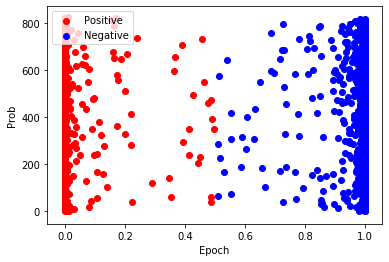

1 :  (816,)
0 :  (824,)


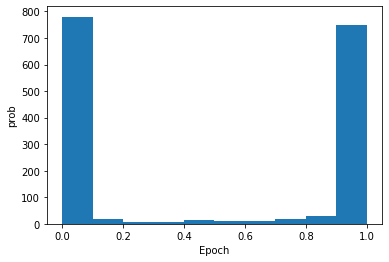

score :         loss       acc       rec       pre        f1
0  0.179425  0.952439  0.948216  0.955802  0.950098


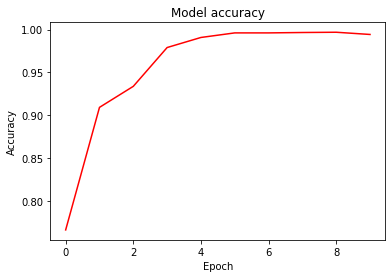

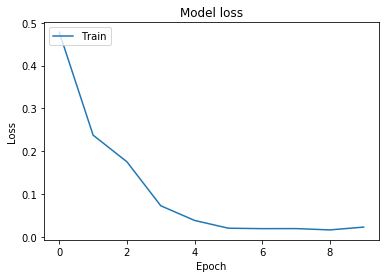

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 9s 1ms/sample - loss: 0.4727 - acc: 0.7605 - recall_m: 0.7563 - precision_m: 0.7843 - f1_m: 0.7425
Epoch 2/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.2179 - acc: 0.9154 - recall_m: 0.9371 - precision_m: 0.8993 - f1_m: 0.9162
Epoch 3/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.1310 - acc: 0.9540 - recall_m: 0.9663 - precision_m: 0.9457 - f1_m: 0.9545
Epoch 4/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0609 - acc: 0.9817 - recall_m: 0.9860 - precision_m: 0.9773 - f1_m: 0.9813
Epoch 5/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0277 - acc: 0.9944 - recall_m: 0.9964 - precision_m: 0.9925 - f1_m: 0.9944
Epoch 6/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0184 - acc: 0.9971 - recall_m: 0.9977 - precision_m: 0.9967 - f1_m: 0.9972
Epoch 7/10
6560/6560 [==========================

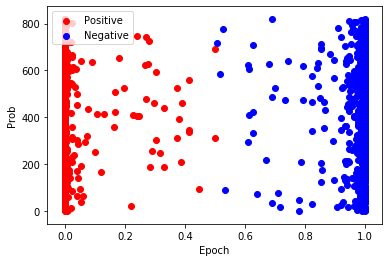

1 :  (820,)
0 :  (820,)


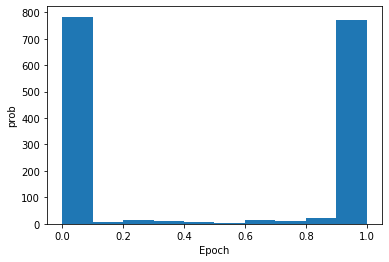

score :         loss       acc       rec       pre        f1
0  0.179425  0.952439  0.948216  0.955802  0.950098
1  0.220200  0.950000  0.914741  0.916616  0.914931


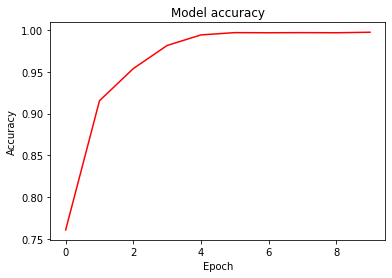

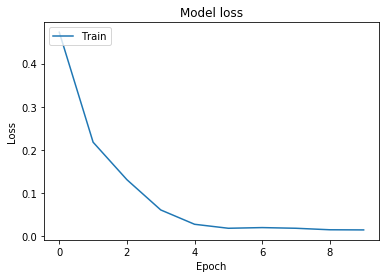

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.4712 - acc: 0.7494 - recall_m: 0.7269 - precision_m: 0.7451 - f1_m: 0.7100
Epoch 2/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.2456 - acc: 0.9037 - recall_m: 0.9246 - precision_m: 0.8925 - f1_m: 0.9037
Epoch 3/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.1284 - acc: 0.9588 - recall_m: 0.9736 - precision_m: 0.9478 - f1_m: 0.9599
Epoch 4/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0781 - acc: 0.9747 - recall_m: 0.9802 - precision_m: 0.9709 - f1_m: 0.9749
Epoch 5/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0332 - acc: 0.9921 - recall_m: 0.9947 - precision_m: 0.9890 - f1_m: 0.9917
Epoch 6/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0249 - acc: 0.9948 - recall_m: 0.9956 - precision_m: 0.9943 - f1_m: 0.9949
Epoch 7/10
6560/6560 [=========================

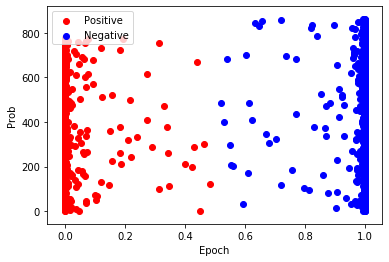

1 :  (863,)
0 :  (777,)


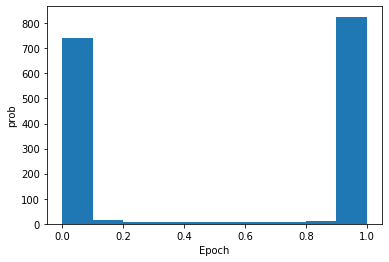

score :         loss       acc       rec       pre        f1
0  0.179425  0.952439  0.948216  0.955802  0.950098
1  0.220200  0.950000  0.914741  0.916616  0.914931
2  0.269684  0.934756  0.959251  0.912010  0.933389


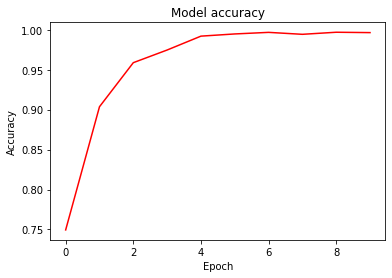

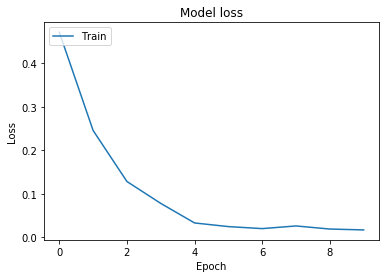

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 9s 1ms/sample - loss: 0.4423 - acc: 0.7806 - recall_m: 0.7910 - precision_m: 0.7903 - f1_m: 0.7751
Epoch 2/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.1896 - acc: 0.9299 - recall_m: 0.9444 - precision_m: 0.9198 - f1_m: 0.9307
Epoch 3/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0866 - acc: 0.9715 - recall_m: 0.9766 - precision_m: 0.9671 - f1_m: 0.9715
Epoch 4/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0409 - acc: 0.9889 - recall_m: 0.9912 - precision_m: 0.9872 - f1_m: 0.9890
Epoch 5/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0603 - acc: 0.9803 - recall_m: 0.9827 - precision_m: 0.9811 - f1_m: 0.9811
Epoch 6/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0201 - acc: 0.9956 - recall_m: 0.9961 - precision_m: 0.9954 - f1_m: 0.9957
Epoch 7/10
6560/6560 [==========================

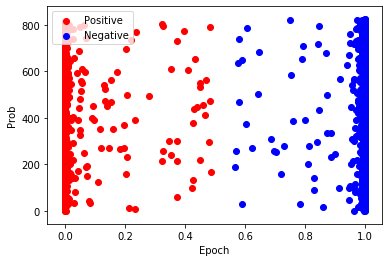

1 :  (825,)
0 :  (815,)


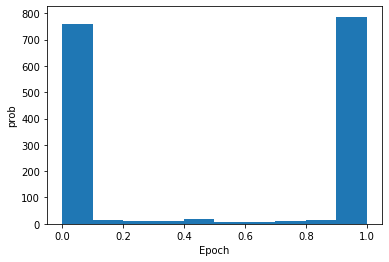

score :         loss       acc       rec       pre        f1
0  0.179425  0.952439  0.948216  0.955802  0.950098
1  0.220200  0.950000  0.914741  0.916616  0.914931
2  0.269684  0.934756  0.959251  0.912010  0.933389
3  0.212531  0.946951  0.930827  0.927638  0.927681


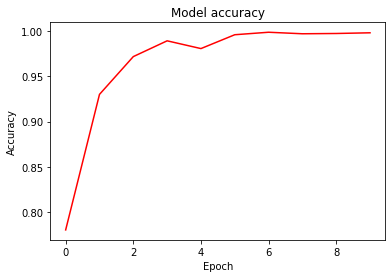

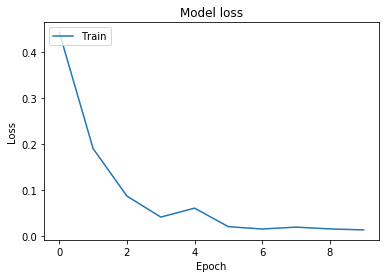

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 9s 1ms/sample - loss: 0.4180 - acc: 0.7998 - recall_m: 0.7962 - precision_m: 0.8036 - f1_m: 0.7927
Epoch 2/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.2067 - acc: 0.9209 - recall_m: 0.9349 - precision_m: 0.9104 - f1_m: 0.9195
Epoch 3/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.1086 - acc: 0.9655 - recall_m: 0.9757 - precision_m: 0.9566 - f1_m: 0.9654
Epoch 4/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0616 - acc: 0.9816 - recall_m: 0.9837 - precision_m: 0.9804 - f1_m: 0.9815
Epoch 5/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.1330 - acc: 0.9564 - recall_m: 0.9624 - precision_m: 0.9575 - f1_m: 0.9561
Epoch 6/10
6560/6560 [==============================] - 8s 1ms/sample - loss: 0.0258 - acc: 0.9948 - recall_m: 0.9958 - precision_m: 0.9932 - f1_m: 0.9944
Epoch 7/10
6560/6560 [==========================

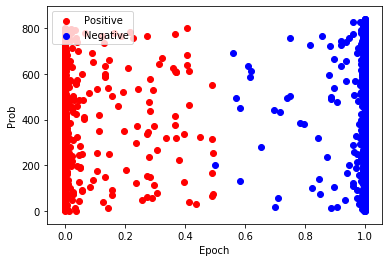

1 :  (840,)
0 :  (800,)


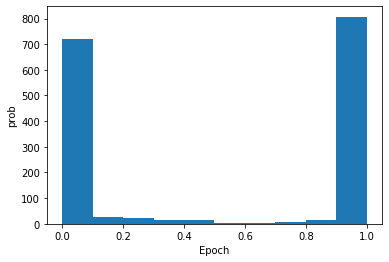

score :         loss       acc       rec       pre        f1
0  0.179425  0.952439  0.948216  0.955802  0.950098
1  0.220200  0.950000  0.914741  0.916616  0.914931
2  0.269684  0.934756  0.959251  0.912010  0.933389
3  0.212531  0.946951  0.930827  0.927638  0.927681
4  0.232110  0.946341  0.957857  0.934965  0.944580


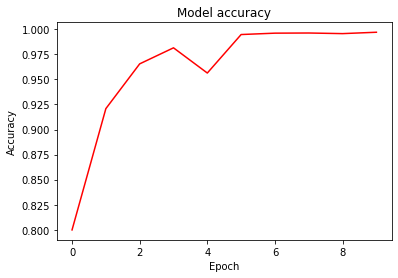

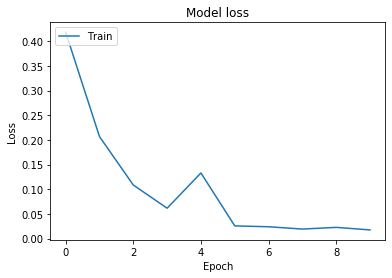

In [33]:
from sklearn.metrics import precision_recall_curve
skf = StratifiedKFold(n_splits=5)
score = pd.DataFrame(columns=['loss','acc','rec','pre','f1'])
index = 0
for train , test in skf.split(x,y_):
    cnnf_model= build_model(embedding_layer,max_len)
    xtrain,ytrain = x[train],y_[train]
    xtest,ytest = x[test],y_[test]
    history = cnnf_model.fit(xtrain, ytrain, epochs=10, batch_size=128)
    ##############
    pred = cnnf_model.predict(xtest) 
    pred_n = pred[pred>=0.5]
    pred_p = pred[pred<0.5]
    plt.scatter(pred_p,range(len(pred_p)),c = 'r')
    plt.scatter(pred_n,range(len(pred_n)),c = 'b')
    plt.ylabel('Prob')
    plt.xlabel('Epoch')
    plt.legend(['Positive','Negative'], loc='upper left')
    plt.show()
    ##########
    pd.Series(pred[:,0]).plot(kind='hist')
    plt.ylabel('prob')
    plt.xlabel('Epoch')
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    print('1 : ', pred[pred==1].shape)
    print('0 : ' ,pred[pred==0].shape)
    plt.show()
    #################
    val = cnnf_model.evaluate(xtest, ytest,verbose = 0)
    score.loc[index] = val
    index += 1
    print('score : ', score)
    ###########
    plt.plot(history.history['acc'],'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()   

In [34]:
score

,loss,acc,rec,pre,f1
0,0.179425,0.952439,0.948216,0.955802,0.950098
1,0.220200,0.950000,0.914741,0.916616,0.914931
2,0.269684,0.934756,0.959251,0.912010,0.933389
3,0.212531,0.946951,0.930827,0.927638,0.927681
4,0.232110,0.946341,0.957857,0.934965,0.944580


(1290, 64)


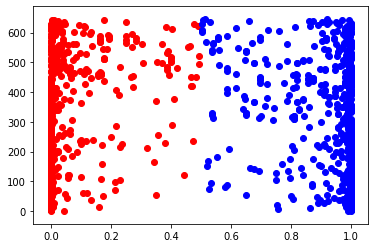

1 :  (646,)
0 :  (644,)


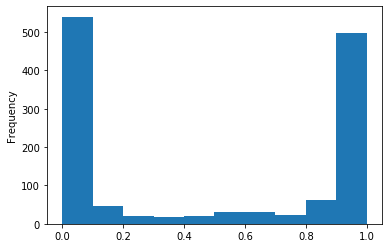

In [35]:
print(x_test.shape)
pred = cnnf_model.predict(x_test) 
pred_n = pred[pred>=0.5]
pred_p = pred[pred<0.5]
plt.scatter(pred_p,range(len(pred_p)),c = 'r')
plt.scatter(pred_n,range(len(pred_n)),c = 'b')
plt.show()
pd.Series(pred[:,0]).plot(kind='hist')
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
print('1 : ', pred[pred==1].shape)
print('0 : ' ,pred[pred==0].shape)

# CNN [Embedding+Trainable]

In [36]:
embedding_layer = Embedding(input_dim = len(word_index)+1 ,output_dim = 300, 
                            weights = [embed_matrix],input_length = max_len,trainable = True )

In [37]:
def build_model(embedding_layer,max_len):
    sequence_input = Input(shape=(max_len,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 3, activation='relu')(embedded_sequences)
    x = MaxPooling1D(3)(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)  # global max pooling
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(1, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=['acc',f1_m,precision_m, recall_m])
    return model


Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 13s 2ms/sample - loss: 0.4562 - acc: 0.7732 - f1_m: 0.7628 - precision_m: 0.7866 - recall_m: 0.7718
Epoch 2/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.1914 - acc: 0.9316 - f1_m: 0.9319 - precision_m: 0.9180 - recall_m: 0.9487
Epoch 3/10
6560/6560 [==============================] - 10s 2ms/sample - loss: 0.0842 - acc: 0.9729 - f1_m: 0.9727 - precision_m: 0.9655 - recall_m: 0.9810
Epoch 4/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.0474 - acc: 0.9875 - f1_m: 0.9876 - precision_m: 0.9861 - recall_m: 0.9895
Epoch 5/10
6560/6560 [==============================] - 10s 2ms/sample - loss: 0.0230 - acc: 0.9950 - f1_m: 0.9946 - precision_m: 0.9931 - recall_m: 0.9961
Epoch 6/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.0253 - acc: 0.9936 - f1_m: 0.9936 - precision_m: 0.9932 - recall_m: 0.9943
Epoch 7/10
6560/6560 [====================

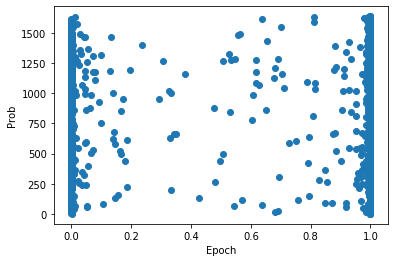

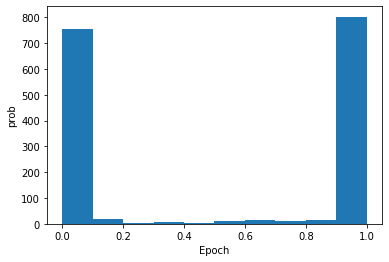

score :         loss       acc       rec       pre        f1
0  0.179441  0.947561  0.945031  0.927489  0.966344


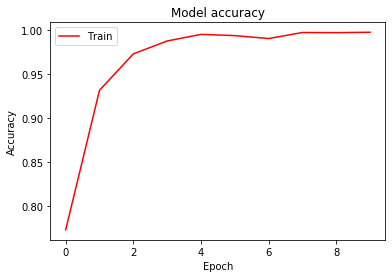

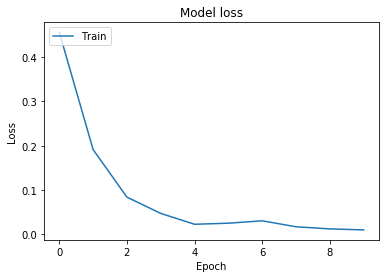

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 11s 2ms/sample - loss: 0.3757 - acc: 0.8130 - f1_m: 0.8058 - precision_m: 0.8247 - recall_m: 0.8182
Epoch 2/10
6560/6560 [==============================] - 10s 2ms/sample - loss: 0.1121 - acc: 0.9630 - f1_m: 0.9632 - precision_m: 0.9581 - recall_m: 0.9694
Epoch 3/10
6560/6560 [==============================] - 10s 2ms/sample - loss: 0.0533 - acc: 0.9832 - f1_m: 0.9834 - precision_m: 0.9817 - recall_m: 0.9856
Epoch 4/10
6560/6560 [==============================] - 10s 2ms/sample - loss: 0.0237 - acc: 0.9945 - f1_m: 0.9940 - precision_m: 0.9922 - recall_m: 0.9959
Epoch 5/10
6560/6560 [==============================] - 9s 1ms/sample - loss: 0.0202 - acc: 0.9962 - f1_m: 0.9962 - precision_m: 0.9951 - recall_m: 0.9975
Epoch 6/10
6560/6560 [==============================] - 9s 1ms/sample - loss: 0.0186 - acc: 0.9970 - f1_m: 0.9970 - precision_m: 0.9964 - recall_m: 0.9976
Epoch 7/10
6560/6560 [======================

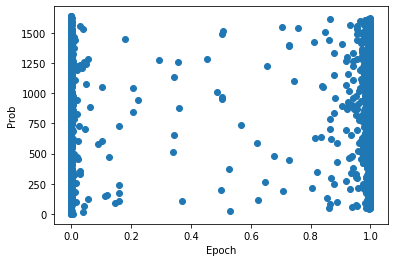

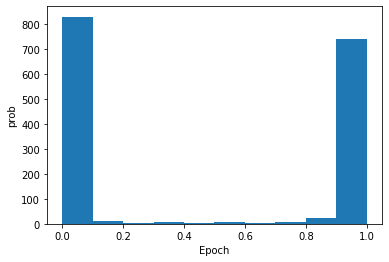

score :         loss       acc       rec       pre        f1
0  0.179441  0.947561  0.945031  0.927489  0.966344
1  0.190725  0.964024  0.925619  0.946969  0.906929


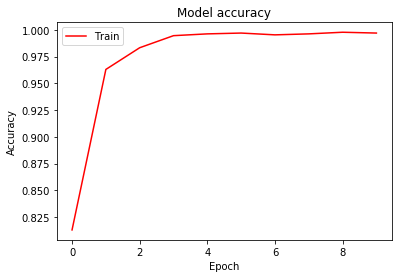

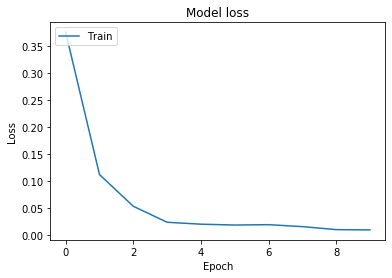

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 11s 2ms/sample - loss: 0.3089 - acc: 0.8598 - f1_m: 0.8465 - precision_m: 0.8747 - recall_m: 0.8616
Epoch 2/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.0691 - acc: 0.9777 - f1_m: 0.9783 - precision_m: 0.9760 - recall_m: 0.9811
Epoch 3/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.0291 - acc: 0.9912 - f1_m: 0.9912 - precision_m: 0.9895 - recall_m: 0.9932
Epoch 4/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.0227 - acc: 0.9945 - f1_m: 0.9945 - precision_m: 0.9935 - recall_m: 0.9955
Epoch 5/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.0222 - acc: 0.9942 - f1_m: 0.9927 - precision_m: 0.9937 - recall_m: 0.9922
Epoch 6/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.0273 - acc: 0.9928 - f1_m: 0.9923 - precision_m: 0.9913 - recall_m: 0.9937
Epoch 7/10
6560/6560 [====================

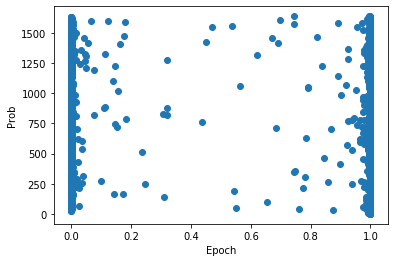

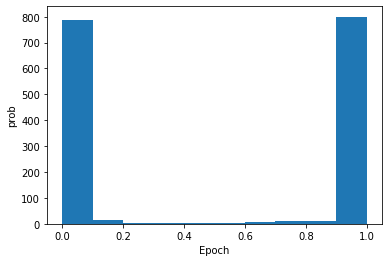

score :         loss       acc       rec       pre        f1
0  0.179441  0.947561  0.945031  0.927489  0.966344
1  0.190725  0.964024  0.925619  0.946969  0.906929
2  0.090495  0.972561  0.971795  0.967269  0.977940


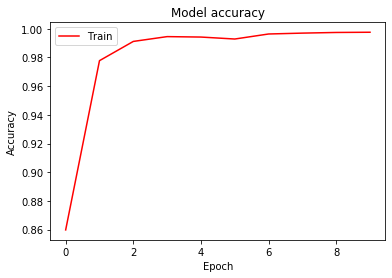

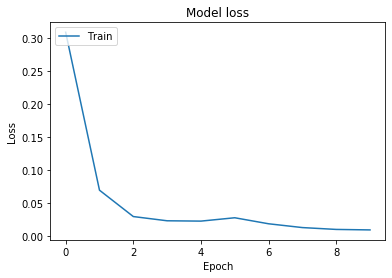

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 11s 2ms/sample - loss: 0.2231 - acc: 0.9061 - f1_m: 0.9065 - precision_m: 0.9053 - recall_m: 0.9122
Epoch 2/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.0508 - acc: 0.9829 - f1_m: 0.9831 - precision_m: 0.9828 - recall_m: 0.9839
Epoch 3/10
6560/6560 [==============================] - 10s 2ms/sample - loss: 0.0280 - acc: 0.9916 - f1_m: 0.9918 - precision_m: 0.9901 - recall_m: 0.9937
Epoch 4/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.0192 - acc: 0.9948 - f1_m: 0.9949 - precision_m: 0.9948 - recall_m: 0.9951
Epoch 5/10
6560/6560 [==============================] - 9s 1ms/sample - loss: 0.0208 - acc: 0.9956 - f1_m: 0.9953 - precision_m: 0.9950 - recall_m: 0.9957
Epoch 6/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.0113 - acc: 0.9973 - f1_m: 0.9973 - precision_m: 0.9965 - recall_m: 0.9981
Epoch 7/10
6560/6560 [=====================

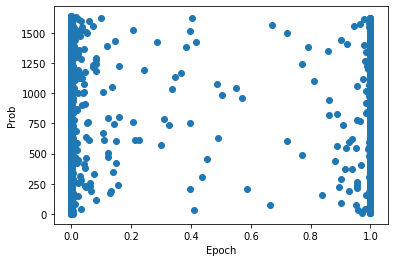

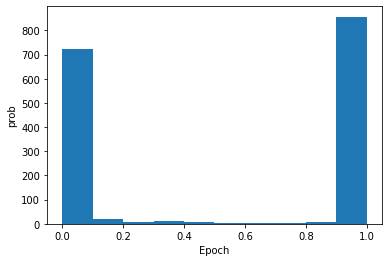

score :         loss       acc       rec       pre        f1
0  0.179441  0.947561  0.945031  0.927489  0.966344
1  0.190725  0.964024  0.925619  0.946969  0.906929
2  0.090495  0.972561  0.971795  0.967269  0.977940
3  0.157511  0.964024  0.945945  0.915720  0.979701


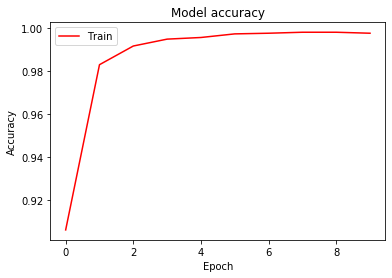

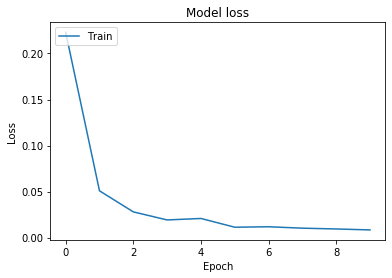

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 11s 2ms/sample - loss: 0.2395 - acc: 0.8939 - f1_m: 0.8816 - precision_m: 0.8953 - recall_m: 0.8968
Epoch 2/10
6560/6560 [==============================] - 10s 2ms/sample - loss: 0.0370 - acc: 0.9913 - f1_m: 0.9914 - precision_m: 0.9884 - recall_m: 0.9945
Epoch 3/10
6560/6560 [==============================] - 10s 2ms/sample - loss: 0.0279 - acc: 0.9933 - f1_m: 0.9933 - precision_m: 0.9935 - recall_m: 0.9933
Epoch 4/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.0170 - acc: 0.9959 - f1_m: 0.9953 - precision_m: 0.9943 - recall_m: 0.9964
Epoch 5/10
6560/6560 [==============================] - 10s 1ms/sample - loss: 0.0158 - acc: 0.9957 - f1_m: 0.9958 - precision_m: 0.9959 - recall_m: 0.9958
Epoch 6/10
6560/6560 [==============================] - 9s 1ms/sample - loss: 0.0140 - acc: 0.9966 - f1_m: 0.9967 - precision_m: 0.9964 - recall_m: 0.9971
Epoch 7/10
6560/6560 [=====================

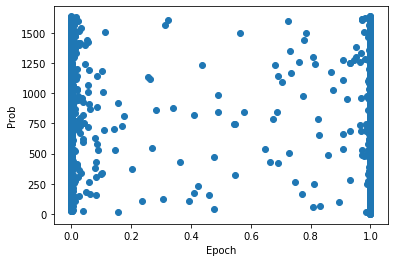

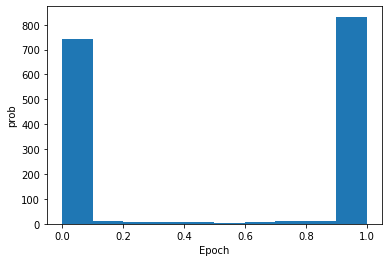

score :         loss       acc       rec       pre        f1
0  0.179441  0.947561  0.945031  0.927489  0.966344
1  0.190725  0.964024  0.925619  0.946969  0.906929
2  0.090495  0.972561  0.971795  0.967269  0.977940
3  0.157511  0.964024  0.945945  0.915720  0.979701
4  0.094270  0.967073  0.967129  0.942092  0.995281


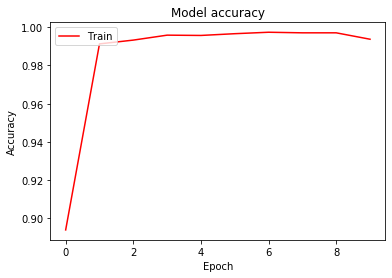

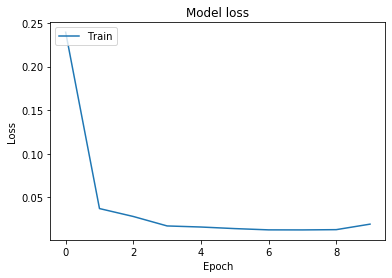

In [38]:
from sklearn.metrics import precision_recall_curve
skf = StratifiedKFold(n_splits=5)
score_t = pd.DataFrame(columns=['loss','acc','rec','pre','f1'])
index = 0
for train , test in skf.split(x,y_):
    cnnt_model= build_model(embedding_layer,max_len)
    xtrain,ytrain = x[train],y_[train]
    xtest,ytest = x[test],y_[test]
    history = cnnt_model.fit(xtrain, ytrain, epochs=10, batch_size=128)
    ##################
    pred = cnnt_model.predict(xtest) 
    plt.scatter(pred,range(len(pred)))
    plt.ylabel('Prob')
    plt.xlabel('Epoch')
    plt.show()
    pd.Series(pred[:,0]).plot(kind='hist')
    plt.ylabel('prob')
    plt.xlabel('Epoch')
    plt.show()
    ######################3
    val = cnnt_model.evaluate(xtest, ytest,verbose = 0)
    score_t.loc[index] = val
    index += 1
    print('score : ', score_t)
    #################3
    plt.plot(history.history['acc'],'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()   

In [39]:
score_t

,loss,acc,rec,pre,f1
0,0.179441,0.947561,0.945031,0.927489,0.966344
1,0.190725,0.964024,0.925619,0.946969,0.906929
2,0.090495,0.972561,0.971795,0.967269,0.977940
3,0.157511,0.964024,0.945945,0.915720,0.979701
4,0.094270,0.967073,0.967129,0.942092,0.995281


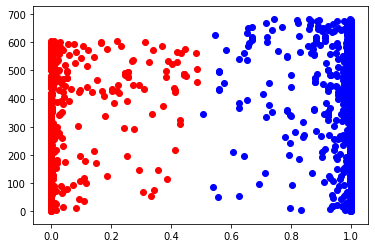

1 :  (684,)
0 :  (606,)


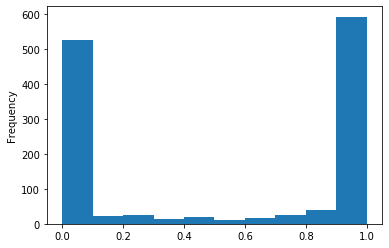

In [40]:
pred = cnnt_model.predict(x_test) 
pred_n = pred[pred>=0.5]
pred_p = pred[pred<0.5]
plt.scatter(pred_p,range(len(pred_p)),c = 'r')
plt.scatter(pred_n,range(len(pred_n)),c = 'b')
plt.show()
pd.Series(pred[:,0]).plot(kind='hist')
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
print('1 : ', pred[pred==1].shape)
print('0 : ' ,pred[pred==0].shape)

# simple network

In [41]:

embedding_layer = Embedding(input_dim = len(word_index)+1 ,output_dim = 300, 
                            weights = [embed_matrix],input_length = max_len,trainable = True )

In [42]:
from tensorflow.keras.layers import TimeDistributed
def build_model(embedding_layer,max_len):
    sequence_input = Input(shape=(max_len,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Flatten()(embedded_sequences)
    x = Dense(1024, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(1, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=['acc',f1_m,precision_m, recall_m])
    return model

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 21s 3ms/sample - loss: 0.3785 - acc: 0.8255 - f1_m: 0.8078 - precision_m: 0.8311 - recall_m: 0.8235
Epoch 2/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0919 - acc: 0.9698 - f1_m: 0.9702 - precision_m: 0.9637 - recall_m: 0.9776
Epoch 3/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0275 - acc: 0.9925 - f1_m: 0.9926 - precision_m: 0.9911 - recall_m: 0.9943
Epoch 4/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0137 - acc: 0.9966 - f1_m: 0.9967 - precision_m: 0.9967 - recall_m: 0.9968
Epoch 5/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0082 - acc: 0.9976 - f1_m: 0.9976 - precision_m: 0.9970 - recall_m: 0.9982
Epoch 6/10
6560/6560 [==============================] - 20s 3ms/sample - loss: 0.0080 - acc: 0.9979 - f1_m: 0.9978 - precision_m: 0.9972 - recall_m: 0.9985
Epoch 7/10
6560/6560 [====================

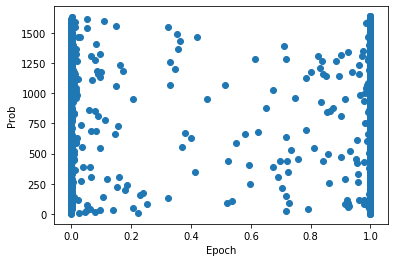

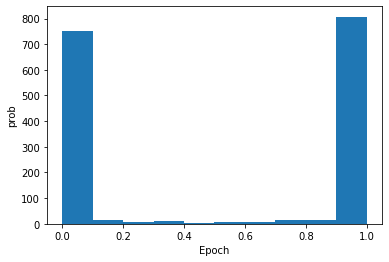

score :         loss       acc       rec       pre        f1
0  0.300032  0.934756  0.933588  0.918417  0.954204


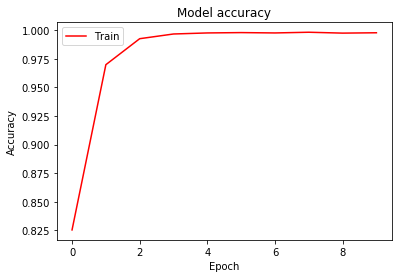

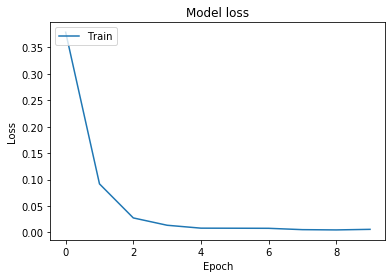

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 20s 3ms/sample - loss: 0.2768 - acc: 0.8774 - f1_m: 0.8759 - precision_m: 0.8810 - recall_m: 0.8846
Epoch 2/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0513 - acc: 0.9852 - f1_m: 0.9849 - precision_m: 0.9843 - recall_m: 0.9859
Epoch 3/10
6560/6560 [==============================] - 20s 3ms/sample - loss: 0.0212 - acc: 0.9953 - f1_m: 0.9954 - precision_m: 0.9941 - recall_m: 0.9969
Epoch 4/10
6560/6560 [==============================] - 18s 3ms/sample - loss: 0.0167 - acc: 0.9963 - f1_m: 0.9964 - precision_m: 0.9974 - recall_m: 0.9954
Epoch 5/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0099 - acc: 0.9979 - f1_m: 0.9979 - precision_m: 0.9968 - recall_m: 0.9991
Epoch 6/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0063 - acc: 0.9977 - f1_m: 0.9973 - precision_m: 0.9968 - recall_m: 0.9980
Epoch 7/10
6560/6560 [====================

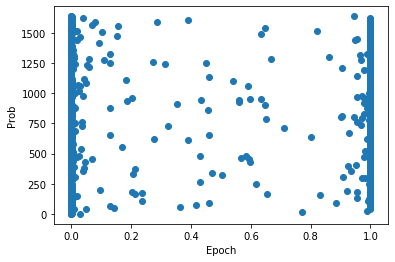

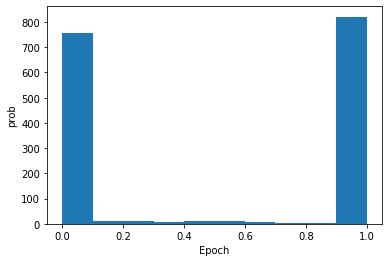

score :         loss       acc       rec       pre        f1
0  0.300032  0.934756  0.933588  0.918417  0.954204
1  0.169131  0.959756  0.924734  0.913102  0.938294


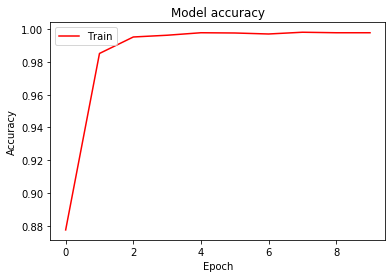

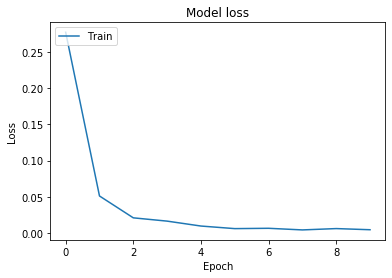

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.2434 - acc: 0.8893 - f1_m: 0.8830 - precision_m: 0.9015 - recall_m: 0.8924
Epoch 2/10
6560/6560 [==============================] - 18s 3ms/sample - loss: 0.0383 - acc: 0.9913 - f1_m: 0.9914 - precision_m: 0.9899 - recall_m: 0.9931
Epoch 3/10
6560/6560 [==============================] - 18s 3ms/sample - loss: 0.0143 - acc: 0.9968 - f1_m: 0.9969 - precision_m: 0.9971 - recall_m: 0.9968
Epoch 4/10
6560/6560 [==============================] - 18s 3ms/sample - loss: 0.0117 - acc: 0.9974 - f1_m: 0.9974 - precision_m: 0.9967 - recall_m: 0.9981
Epoch 5/10
6560/6560 [==============================] - 18s 3ms/sample - loss: 0.0072 - acc: 0.9977 - f1_m: 0.9977 - precision_m: 0.9966 - recall_m: 0.9988
Epoch 6/10
6560/6560 [==============================] - 18s 3ms/sample - loss: 0.0059 - acc: 0.9976 - f1_m: 0.9976 - precision_m: 0.9968 - recall_m: 0.9985
Epoch 7/10
6560/6560 [====================

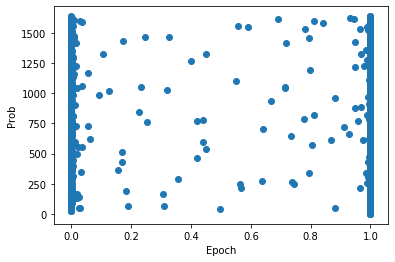

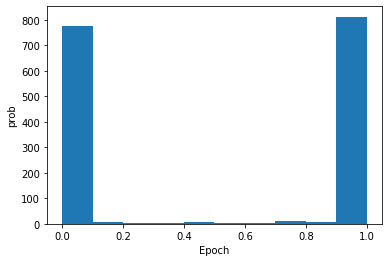

score :         loss       acc       rec       pre        f1
0  0.300032  0.934756  0.933588  0.918417  0.954204
1  0.169131  0.959756  0.924734  0.913102  0.938294
2  0.122615  0.971341  0.970279  0.960942  0.981774


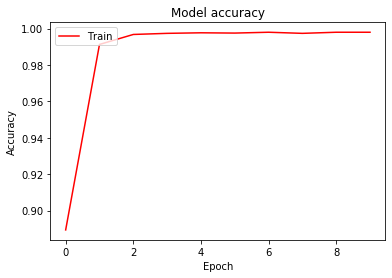

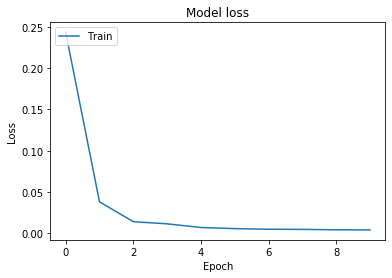

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 20s 3ms/sample - loss: 0.1977 - acc: 0.9181 - f1_m: 0.9137 - precision_m: 0.9226 - recall_m: 0.9121
Epoch 2/10
6560/6560 [==============================] - 18s 3ms/sample - loss: 0.0299 - acc: 0.9927 - f1_m: 0.9922 - precision_m: 0.9907 - recall_m: 0.9940
Epoch 3/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0197 - acc: 0.9960 - f1_m: 0.9962 - precision_m: 0.9964 - recall_m: 0.9960
Epoch 4/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0119 - acc: 0.9971 - f1_m: 0.9971 - precision_m: 0.9977 - recall_m: 0.9965
Epoch 5/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0071 - acc: 0.9982 - f1_m: 0.9976 - precision_m: 0.9973 - recall_m: 0.9981
Epoch 6/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0065 - acc: 0.9980 - f1_m: 0.9980 - precision_m: 0.9970 - recall_m: 0.9991
Epoch 7/10
6560/6560 [====================

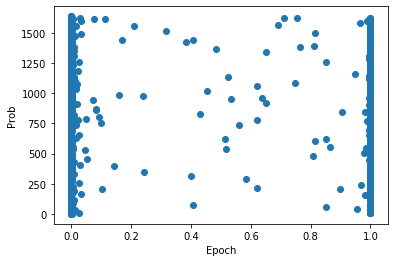

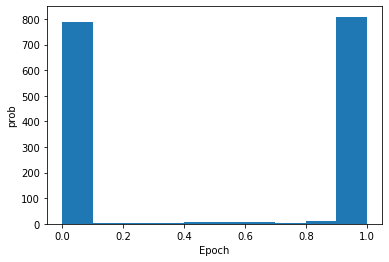

score :         loss       acc       rec       pre        f1
0  0.300032  0.934756  0.933588  0.918417  0.954204
1  0.169131  0.959756  0.924734  0.913102  0.938294
2  0.122615  0.971341  0.970279  0.960942  0.981774
3  0.072015  0.982317  0.963216  0.954919  0.972468


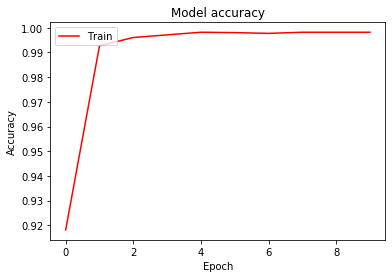

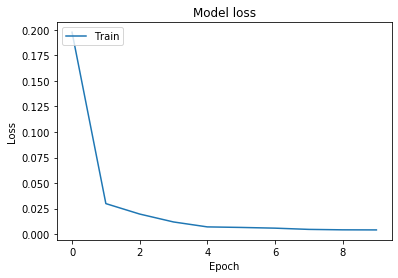

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 20s 3ms/sample - loss: 0.1881 - acc: 0.9174 - f1_m: 0.9104 - precision_m: 0.9258 - recall_m: 0.9194
Epoch 2/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0246 - acc: 0.9941 - f1_m: 0.9941 - precision_m: 0.9933 - recall_m: 0.9950
Epoch 3/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0150 - acc: 0.9962 - f1_m: 0.9959 - precision_m: 0.9963 - recall_m: 0.9955
Epoch 4/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0085 - acc: 0.9973 - f1_m: 0.9973 - precision_m: 0.9958 - recall_m: 0.9988
Epoch 5/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0077 - acc: 0.9974 - f1_m: 0.9974 - precision_m: 0.9963 - recall_m: 0.9985
Epoch 6/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.0068 - acc: 0.9970 - f1_m: 0.9970 - precision_m: 0.9960 - recall_m: 0.9979
Epoch 7/10
6560/6560 [====================

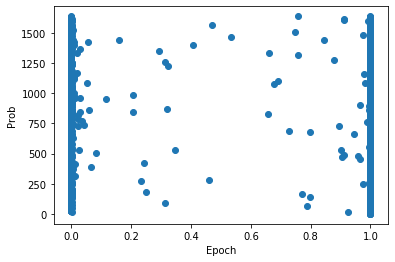

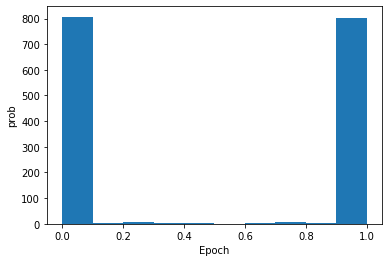

score :         loss       acc       rec       pre        f1
0  0.300032  0.934756  0.933588  0.918417  0.954204
1  0.169131  0.959756  0.924734  0.913102  0.938294
2  0.122615  0.971341  0.970279  0.960942  0.981774
3  0.072015  0.982317  0.963216  0.954919  0.972468
4  0.048602  0.987195  0.987632  0.989637  0.986183


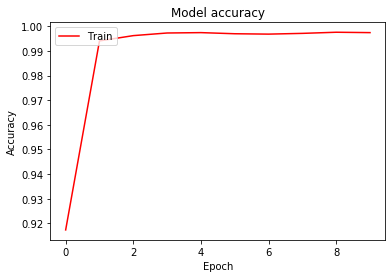

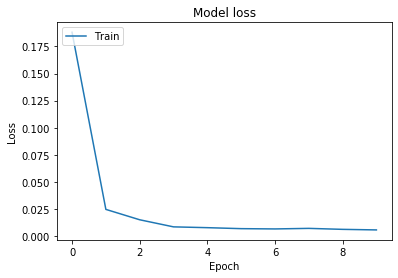

In [43]:
from sklearn.metrics import precision_recall_curve
skf = StratifiedKFold(n_splits=5)
score_s = pd.DataFrame(columns=['loss','acc','rec','pre','f1'])
index = 0
for train , test in skf.split(x,y_):
    simple_model= build_model(embedding_layer,max_len)
    xtrain,ytrain = x[train],y_[train]
    xtest,ytest = x[test],y_[test]
    history = simple_model.fit(xtrain, ytrain, epochs=10, batch_size=128)
    ##################
    pred = simple_model.predict(xtest) 
    plt.scatter(pred,range(len(pred)))
    plt.ylabel('Prob')
    plt.xlabel('Epoch')
    plt.show()
    pd.Series(pred[:,0]).plot(kind='hist')
    plt.ylabel('prob')
    plt.xlabel('Epoch')
    plt.show()
    ######################3
    val = simple_model.evaluate(xtest, ytest,verbose = 0)
    score_s.loc[index] = val
    index += 1
    print('score : ', score_s)
    #################3
    plt.plot(history.history['acc'],'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()   

In [46]:
score_s

,loss,acc,rec,pre,f1
0,0.300032,0.934756,0.933588,0.918417,0.954204
1,0.169131,0.959756,0.924734,0.913102,0.938294
2,0.122615,0.971341,0.970279,0.960942,0.981774
3,0.072015,0.982317,0.963216,0.954919,0.972468
4,0.048602,0.987195,0.987632,0.989637,0.986183


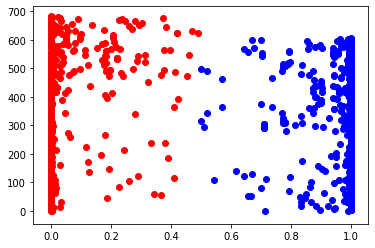

1 :  (606,)
0 :  (684,)


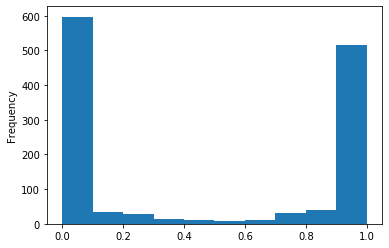

In [47]:
pred = simple_model.predict(x_test) 
pred_n = pred[pred>=0.5]
pred_p = pred[pred<0.5]
plt.scatter(pred_p,range(len(pred_p)),c = 'r')
plt.scatter(pred_n,range(len(pred_n)),c = 'b')
plt.show()
pd.Series(pred[:,0]).plot(kind='hist')
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
print('1 : ', pred[pred==1].shape)
print('0 : ' ,pred[pred==0].shape)

# LSTM MODEL

In [52]:

embedding_layer = Embedding(input_dim = len(word_index)+1 ,output_dim = 300, 
                            weights = [embed_matrix],input_length = max_len,trainable = False )

In [53]:
from tensorflow.keras.layers import LSTM
def build_model(embedding_layer,max_len):
    sequence_input = Input(shape=(max_len,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Bidirectional(LSTM(64))(embedded_sequences)
    x = Dense(64, activation='relu')(x)
    preds = Dense(1, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=['acc',f1_m,precision_m, recall_m])
    return model

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 20s 3ms/sample - loss: 0.4493 - acc: 0.7877 - f1_m: 0.7956 - precision_m: 0.7815 - recall_m: 0.8315
Epoch 2/10
6560/6560 [==============================] - 14s 2ms/sample - loss: 0.2940 - acc: 0.8770 - f1_m: 0.8796 - precision_m: 0.8617 - recall_m: 0.9050
Epoch 3/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.2621 - acc: 0.8931 - f1_m: 0.8934 - precision_m: 0.8771 - recall_m: 0.9160
Epoch 4/10
6560/6560 [==============================] - 14s 2ms/sample - loss: 0.2201 - acc: 0.9104 - f1_m: 0.9115 - precision_m: 0.8971 - recall_m: 0.9287
Epoch 5/10
6560/6560 [==============================] - 14s 2ms/sample - loss: 0.1928 - acc: 0.9293 - f1_m: 0.9307 - precision_m: 0.9151 - recall_m: 0.9494
Epoch 6/10
6560/6560 [==============================] - 14s 2ms/sample - loss: 0.1804 - acc: 0.9319 - f1_m: 0.9303 - precision_m: 0.9167 - recall_m: 0.9470
Epoch 7/10
6560/6560 [====================

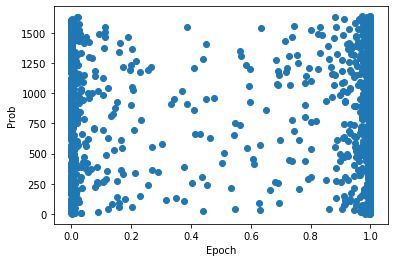

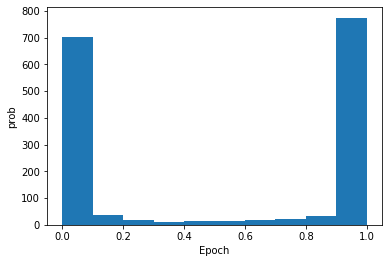

score :         loss       acc       rec       pre       f1
0  0.222606  0.931707  0.930875  0.912097  0.95604


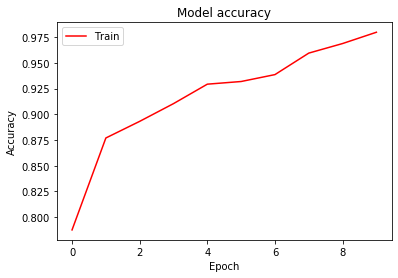

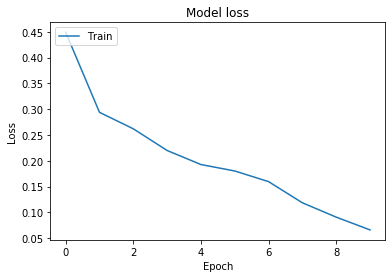

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 22s 3ms/sample - loss: 0.4506 - acc: 0.7991 - f1_m: 0.8029 - precision_m: 0.7905 - recall_m: 0.8278
Epoch 2/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.2836 - acc: 0.8858 - f1_m: 0.8858 - precision_m: 0.8703 - recall_m: 0.9059
Epoch 3/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.2499 - acc: 0.8968 - f1_m: 0.8968 - precision_m: 0.8863 - recall_m: 0.9122
Epoch 4/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.2088 - acc: 0.9177 - f1_m: 0.9185 - precision_m: 0.9000 - recall_m: 0.9393
Epoch 5/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.1842 - acc: 0.9316 - f1_m: 0.9315 - precision_m: 0.9134 - recall_m: 0.9524
Epoch 6/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.1737 - acc: 0.9363 - f1_m: 0.9367 - precision_m: 0.9211 - recall_m: 0.9561
Epoch 7/10
6560/6560 [====================

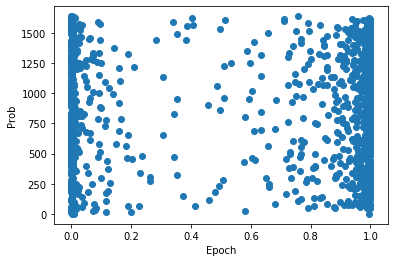

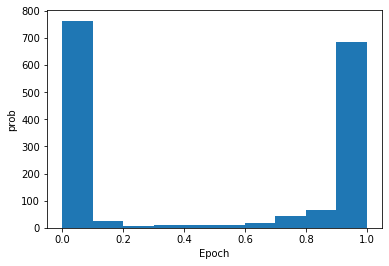

score :         loss       acc       rec       pre        f1
0  0.222606  0.931707  0.930875  0.912097  0.956040
1  0.235318  0.932317  0.895269  0.895864  0.897369


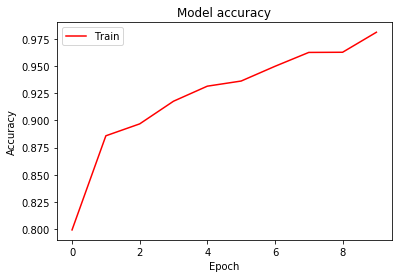

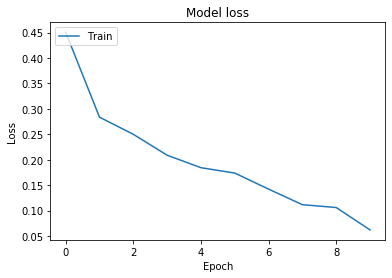

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 24s 4ms/sample - loss: 0.4631 - acc: 0.7748 - f1_m: 0.7670 - precision_m: 0.7730 - recall_m: 0.7933
Epoch 2/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.2910 - acc: 0.8870 - f1_m: 0.8899 - precision_m: 0.8684 - recall_m: 0.9165
Epoch 3/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.2518 - acc: 0.8994 - f1_m: 0.9006 - precision_m: 0.8810 - recall_m: 0.9242
Epoch 4/10
6560/6560 [==============================] - 14s 2ms/sample - loss: 0.2146 - acc: 0.9151 - f1_m: 0.9163 - precision_m: 0.9001 - recall_m: 0.9354
Epoch 5/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.1888 - acc: 0.9288 - f1_m: 0.9305 - precision_m: 0.9118 - recall_m: 0.9518
Epoch 6/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.1770 - acc: 0.9351 - f1_m: 0.9340 - precision_m: 0.9173 - recall_m: 0.9540
Epoch 7/10
6560/6560 [====================

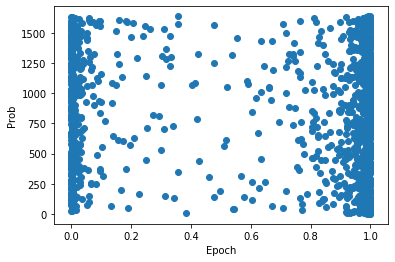

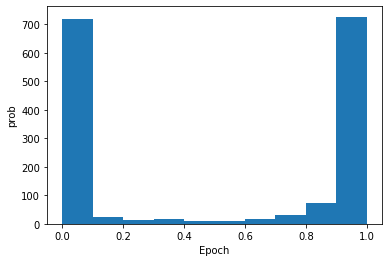

score :         loss       acc       rec       pre        f1
0  0.222606  0.931707  0.930875  0.912097  0.956040
1  0.235318  0.932317  0.895269  0.895864  0.897369
2  0.209279  0.936585  0.935310  0.916123  0.958849


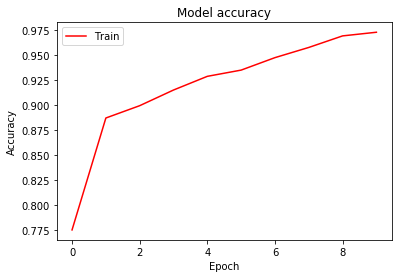

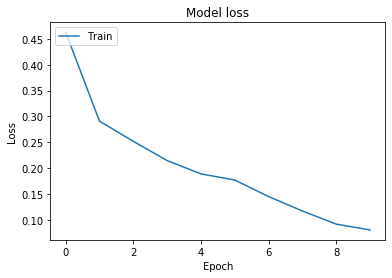

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 19s 3ms/sample - loss: 0.4519 - acc: 0.8015 - f1_m: 0.8126 - precision_m: 0.7902 - recall_m: 0.8501
Epoch 2/10
6560/6560 [==============================] - 14s 2ms/sample - loss: 0.3060 - acc: 0.8721 - f1_m: 0.8736 - precision_m: 0.8559 - recall_m: 0.9006
Epoch 3/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.2466 - acc: 0.9029 - f1_m: 0.9039 - precision_m: 0.8879 - recall_m: 0.9226
Epoch 4/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.2235 - acc: 0.9127 - f1_m: 0.9147 - precision_m: 0.9001 - recall_m: 0.9327
Epoch 5/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.1995 - acc: 0.9218 - f1_m: 0.9232 - precision_m: 0.9097 - recall_m: 0.9406
Epoch 6/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.1628 - acc: 0.9410 - f1_m: 0.9415 - precision_m: 0.9271 - recall_m: 0.9581
Epoch 7/10
6560/6560 [====================

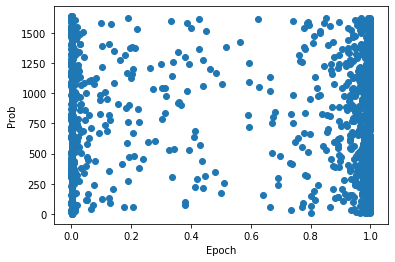

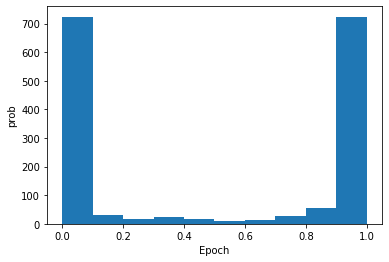

score :         loss       acc       rec       pre        f1
0  0.222606  0.931707  0.930875  0.912097  0.956040
1  0.235318  0.932317  0.895269  0.895864  0.897369
2  0.209279  0.936585  0.935310  0.916123  0.958849
3  0.262042  0.925000  0.906143  0.902310  0.914213


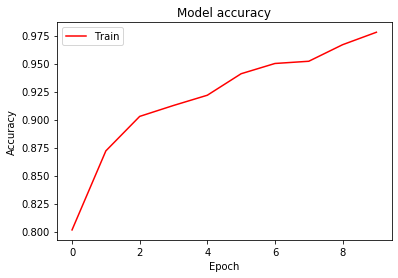

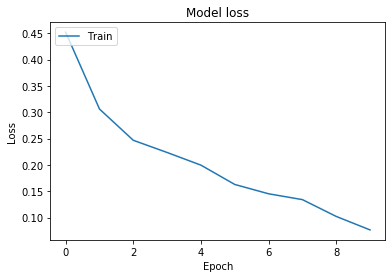

Train on 6560 samples
Epoch 1/10
6560/6560 [==============================] - 25s 4ms/sample - loss: 0.4388 - acc: 0.7980 - f1_m: 0.8040 - precision_m: 0.7886 - recall_m: 0.8297
Epoch 2/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.2715 - acc: 0.8927 - f1_m: 0.8954 - precision_m: 0.8721 - recall_m: 0.9225
Epoch 3/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.2369 - acc: 0.9062 - f1_m: 0.9083 - precision_m: 0.8871 - recall_m: 0.9334
Epoch 4/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.2133 - acc: 0.9187 - f1_m: 0.9197 - precision_m: 0.9000 - recall_m: 0.9427
Epoch 5/10
6560/6560 [==============================] - 14s 2ms/sample - loss: 0.1869 - acc: 0.9303 - f1_m: 0.9308 - precision_m: 0.9134 - recall_m: 0.9518
Epoch 6/10
6560/6560 [==============================] - 15s 2ms/sample - loss: 0.1664 - acc: 0.9370 - f1_m: 0.9375 - precision_m: 0.9232 - recall_m: 0.9557
Epoch 7/10
6560/6560 [====================

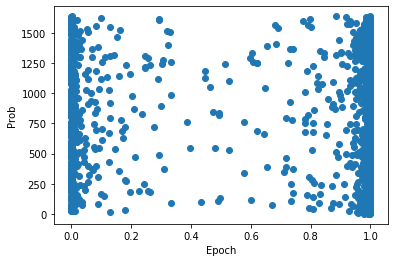

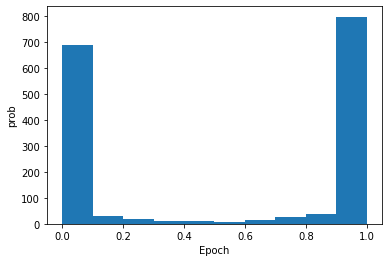

score :         loss       acc       rec       pre        f1
0  0.222606  0.931707  0.930875  0.912097  0.956040
1  0.235318  0.932317  0.895269  0.895864  0.897369
2  0.209279  0.936585  0.935310  0.916123  0.958849
3  0.262042  0.925000  0.906143  0.902310  0.914213
4  0.232294  0.929878  0.930003  0.899158  0.967372


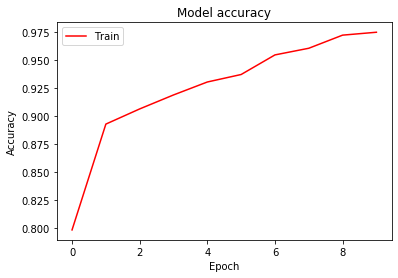

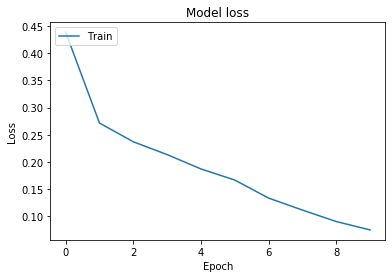

In [54]:
skf = StratifiedKFold(n_splits=5)
score_l = pd.DataFrame(columns=['loss','acc','rec','pre','f1'])
index = 0
for train , test in skf.split(x,y_):
    lstm_model= build_model(embedding_layer,max_len)
    xtrain,ytrain = x[train],y_[train]
    xtest,ytest = x[test],y_[test]
    history = lstm_model.fit(xtrain, ytrain, epochs=10, batch_size=128)
    ##################
    pred = lstm_model.predict(xtest) 
    plt.scatter(pred,range(len(pred)))
    plt.ylabel('Prob')
    plt.xlabel('Epoch')
    plt.show()
    pd.Series(pred[:,0]).plot(kind='hist')
    plt.ylabel('prob')
    plt.xlabel('Epoch')
    plt.show()
    ######################3
    val = lstm_model.evaluate(xtest, ytest,verbose = 0)
    score_l.loc[index] = val
    index += 1
    print('score : ', score_l)
    #################3
    plt.plot(history.history['acc'],'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()   

In [227]:
score_l

,loss,acc,rec,pre,f1
0,0.276436,0.929878,0.927278,0.891391,0.972049
1,0.221922,0.935976,0.912868,0.921725,0.909904
2,0.222036,0.927439,0.869181,0.884754,0.858338
3,0.192092,0.934146,0.910727,0.925157,0.902158
4,0.274899,0.916463,0.920533,0.872788,0.981022


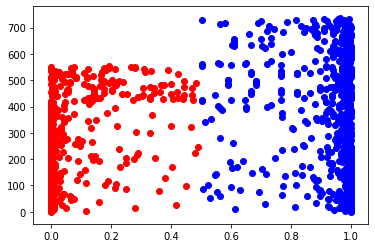

1 :  (736,)
0 :  (554,)


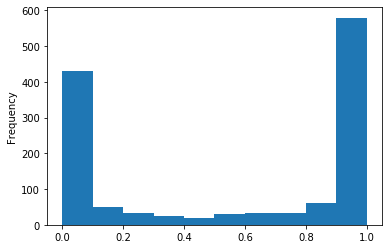

In [235]:
pred = lstm_model.predict(x_test) 
pred_n = pred[pred>=0.5]
pred_p = pred[pred<0.5]
plt.scatter(pred_p,range(len(pred_p)),c = 'r')
plt.scatter(pred_n,range(len(pred_n)),c = 'b')
plt.show()
pd.Series(pred[:,0]).plot(kind='hist')
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
print('1 : ', pred[pred==1].shape)
print('0 : ' ,pred[pred==0].shape)